In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import FastICA
from pandas import DataFrame, Series
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import io

%matplotlib inline
np.set_printoptions(precision=3 , suppress= True)

In [19]:
#importing the file and defining the columns I am going to work with:
filePath = './pord.txt'
columnsName = ['YYMMMDD', '_north(m)', 'sig_n(m)']
site = pd.read_csv(filePath, usecols = columnsName, delimiter = '\s+')
site

,YYMMMDD,_north(m),sig_n(m)
0,06AUG25,0.502569,0.000978
1,06AUG26,0.499765,0.000970
2,06AUG27,0.501145,0.001004
3,06AUG28,0.501418,0.000986
4,06AUG29,0.502944,0.001035
...,...,...,...
5869,22DEC27,0.784341,0.000840
5870,22DEC28,0.784223,0.000866
5871,22DEC29,0.782839,0.000829
5872,22DEC30,0.780768,0.000833


In [20]:
#changing the dtype of 'YYMMMDD':
site['YYMMMDD'] = pd.to_datetime(site['YYMMMDD'], format='%y%b%d')
site['YYMMMDD']

0      2006-08-25
1      2006-08-26
2      2006-08-27
3      2006-08-28
4      2006-08-29
          ...    
5869   2022-12-27
5870   2022-12-28
5871   2022-12-29
5872   2022-12-30
5873   2022-12-31
Name: YYMMMDD, Length: 5874, dtype: datetime64[ns]

In [21]:
#setting 'YYMMMDD' as index:
site.set_index('YYMMMDD', inplace = True)
site

,_north(m),sig_n(m)
YYMMMDD,,
2006-08-25,0.502569,0.000978
2006-08-26,0.499765,0.000970
2006-08-27,0.501145,0.001004
2006-08-28,0.501418,0.000986
2006-08-29,0.502944,0.001035
...,...,...
2022-12-27,0.784341,0.000840
2022-12-28,0.784223,0.000866
2022-12-29,0.782839,0.000829


In [22]:
#creating a new instance with a new period for the time series:
sitePeriodTime = site.loc['2006-08-25':'2022-12-31']
sitePeriodTime

,_north(m),sig_n(m)
YYMMMDD,,
2006-08-25,0.502569,0.000978
2006-08-26,0.499765,0.000970
2006-08-27,0.501145,0.001004
2006-08-28,0.501418,0.000986
2006-08-29,0.502944,0.001035
...,...,...
2022-12-27,0.784341,0.000840
2022-12-28,0.784223,0.000866
2022-12-29,0.782839,0.000829


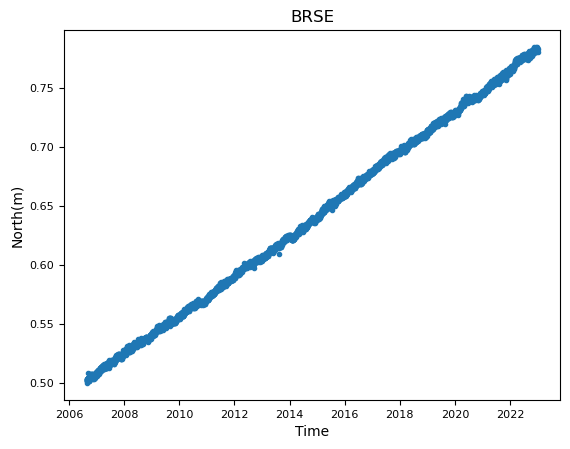

In [23]:
#checking the if the ts is stationarity for east:
plt.plot(sitePeriodTime.index, sitePeriodTime['_north(m)'], '.')
plt.title('BRSE')
plt.xlabel('Time')
plt.xticks(fontsize=8)
plt.ylabel('North(m)')
plt.yticks(fontsize=8)
plt.show()

In [24]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

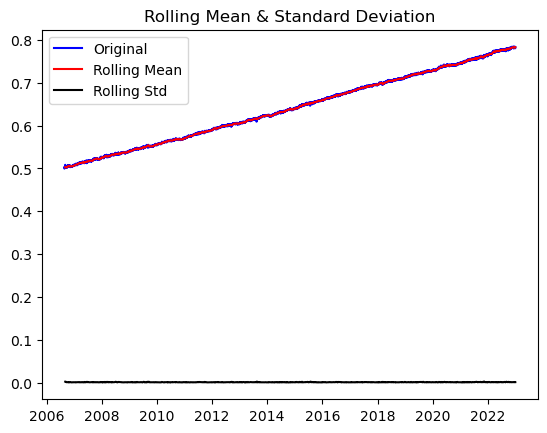

Results of Dickey-Fuller Test:
Test Statistic                    0.428551
p-value                           0.982532
#Lags Used                       28.000000
Number of Observations Used    5845.000000
Critical Value (1%)              -3.431469
Critical Value (5%)              -2.862035
Critical Value (10%)             -2.567033
dtype: float64


In [25]:
test_stationarity(sitePeriodTime['_north(m)'])

In [26]:
tsLogN = np.log1p(sitePeriodTime['_north(m)'])
tsLogN

YYMMMDD
2006-08-25    0.407176
2006-08-26    0.405308
2006-08-27    0.406228
2006-08-28    0.406410
2006-08-29    0.407426
                ...   
2022-12-27    0.579049
2022-12-28    0.578983
2022-12-29    0.578207
2022-12-30    0.577045
2022-12-31    0.578300
Name: _north(m), Length: 5874, dtype: float64

In [27]:
tsLogN_df = pd.DataFrame(tsLogN, index=tsLogN.index)
tsLogN_df

,_north(m)
YYMMMDD,
2006-08-25,0.407176
2006-08-26,0.405308
2006-08-27,0.406228
2006-08-28,0.406410
2006-08-29,0.407426
...,...
2022-12-27,0.579049
2022-12-28,0.578983
2022-12-29,0.578207


In [28]:
tsLogDiffN = tsLogN - tsLogN.shift()
tsLogDiffN

YYMMMDD
2006-08-25         NaN
2006-08-26   -0.001868
2006-08-27    0.000920
2006-08-28    0.000182
2006-08-29    0.001016
                ...   
2022-12-27    0.000374
2022-12-28   -0.000066
2022-12-29   -0.000776
2022-12-30   -0.001162
2022-12-31    0.001255
Name: _north(m), Length: 5874, dtype: float64

In [29]:
tsLogDiffN.dropna(inplace = True)
tsLogDiffN

YYMMMDD
2006-08-26   -0.001868
2006-08-27    0.000920
2006-08-28    0.000182
2006-08-29    0.001016
2006-08-30   -0.000911
                ...   
2022-12-27    0.000374
2022-12-28   -0.000066
2022-12-29   -0.000776
2022-12-30   -0.001162
2022-12-31    0.001255
Name: _north(m), Length: 5873, dtype: float64

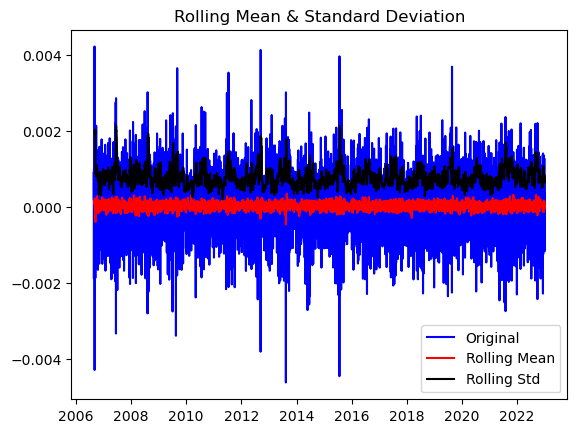

Results of Dickey-Fuller Test:
Test Statistic                  -19.909567
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    5845.000000
Critical Value (1%)              -3.431469
Critical Value (5%)              -2.862035
Critical Value (10%)             -2.567033
dtype: float64


In [30]:
test_stationarity(tsLogDiffN)

In [31]:
tsLogDiffN_df = pd.DataFrame(tsLogDiffN, index=tsLogDiffN.index)
tsLogDiffN_df

,_north(m)
YYMMMDD,
2006-08-26,-0.001868
2006-08-27,0.000920
2006-08-28,0.000182
2006-08-29,0.001016
2006-08-30,-0.000911
...,...
2022-12-27,0.000374
2022-12-28,-0.000066
2022-12-29,-0.000776


In [32]:
limiarZ = 1.0
tsLogDiffN_noOut = tsLogDiffN_df[(np.abs(tsLogDiffN_df-tsLogDiffN_df.mean()) 
                                              < limiarZ*tsLogDiffN_df.std())]
tsLogDiffN_noOut

,_north(m)
YYMMMDD,
2006-08-26,NaN
2006-08-27,NaN
2006-08-28,0.000182
2006-08-29,NaN
2006-08-30,NaN
...,...
2022-12-27,0.000374
2022-12-28,-0.000066
2022-12-29,NaN


In [37]:
#removing the rows with missing values
tsLogDiffN_noOut.dropna(inplace=True)
tsLogDiffN_noOut

,_north(m)
YYMMMDD,
2006-08-28,0.000182
2006-08-31,0.000485
2006-09-01,0.000645
2006-09-02,-0.000023
2006-09-03,-0.000233
...,...
2022-12-24,-0.000285
2022-12-25,0.000246
2022-12-26,0.000220


from statsmodels.tsa.seasonal import seasonal_decompose

#data frame before checking the outliers
decompositionN = seasonal_decompose(tsLogDiffN_df, period=365)
trendN = decompositionN.trend
seasonalN = decompositionN.seasonal
residualN = decompositionN.resid

plt.subplot(411) 
plt.plot(tsLogDiffN_df, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trendN, label='T') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonalN,label='S') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residualN, label='R') 
plt.legend(loc='best') 
plt.tight_layout()

#making a copy of the data 
tsLogDiffN_noOut2= tsLogDiffN_noOut

#replacing the missing values for the mean
tsLogDiffN_noOut2.fillna(tsLogDiffN_noOut2.mean(), inplace = True)


plt.subplot(411) 
plt.plot(tsLogDiffN_noOut, label='rem')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(tsLogDiffN_noOut2, label='rep') 
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best') 

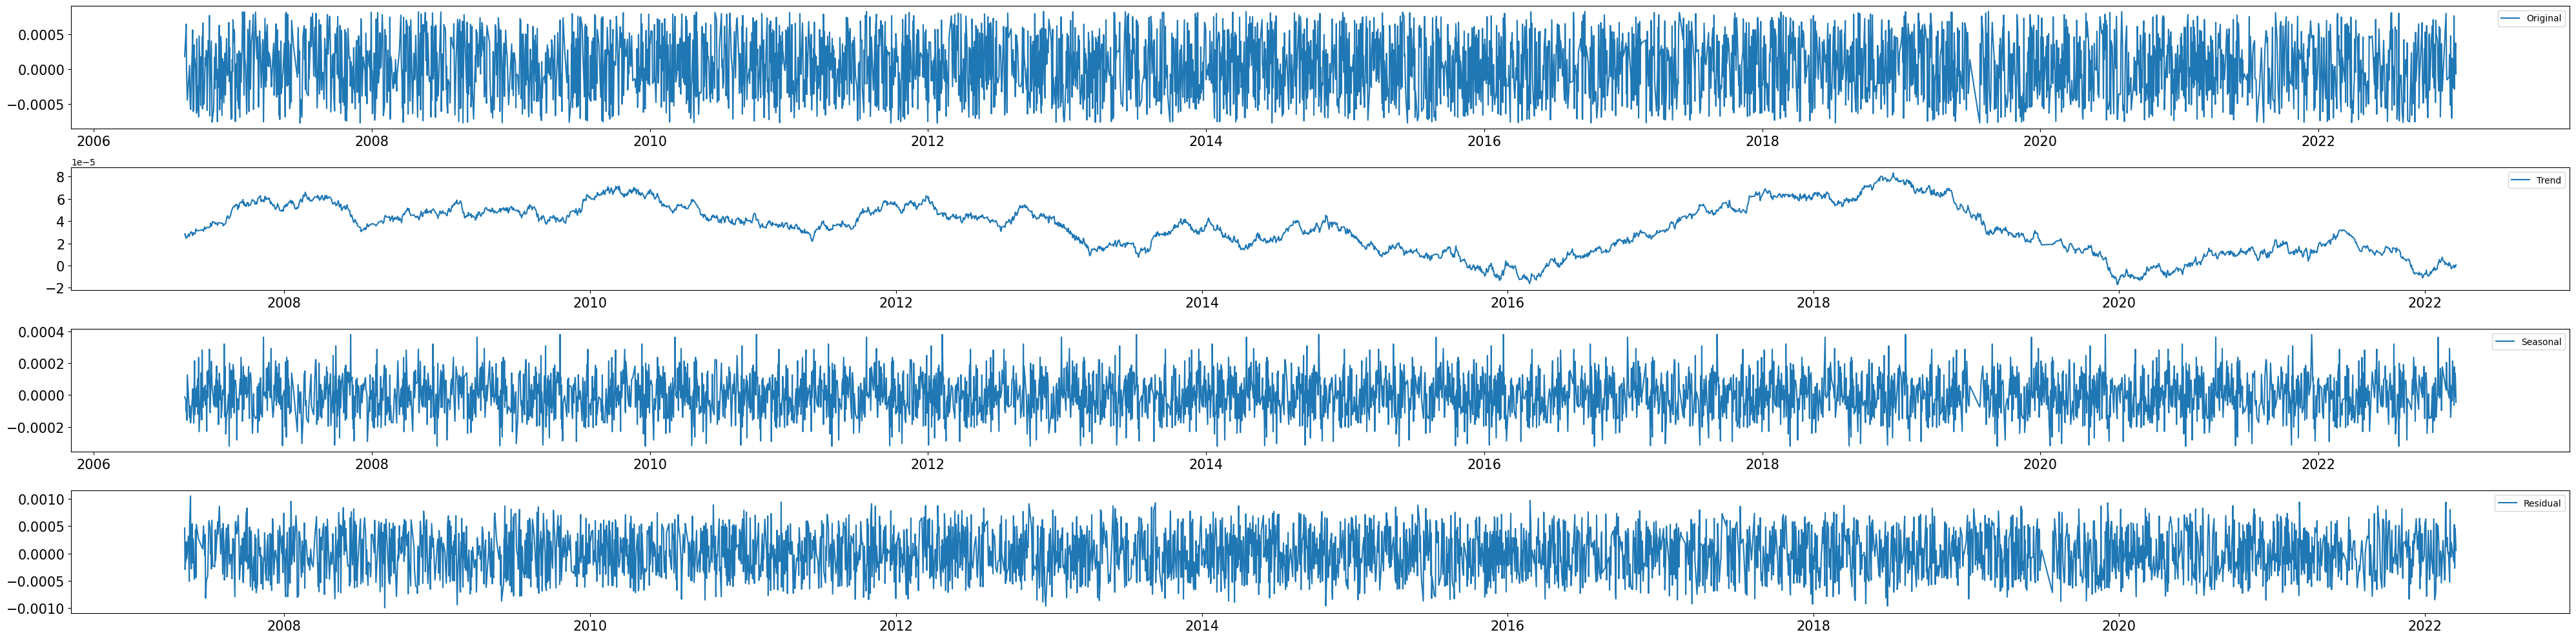

In [39]:
#data frame with outliers removed 

from statsmodels.tsa.seasonal import seasonal_decompose

decompositionN_outRem = seasonal_decompose(tsLogDiffN_noOut, period=365)
trendN_outRem = decompositionN_outRem.trend
seasonalN_outRem = decompositionN_outRem.seasonal
residualN_outRem = decompositionN_outRem.resid

fig=plt.figure(figsize=(40,10))

plt.subplot(411) 
plt.plot(tsLogDiffN_noOut, label='Original') 
plt.legend(loc='best')
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(412) 
plt.plot(trendN_outRem, label='Trend') 
plt.legend(loc='best') 
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(413) 
plt.plot(seasonalN_outRem,label='Seasonal') 
plt.legend(loc='best')
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

plt.subplot(414) 
plt.plot(residualN_outRem, label='Residual') 
plt.legend(loc='best') 
plt.xticks(fontsize=15)
#plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.yticks(fontsize=15)

fl = 'pord_decomposition_north.svg'
f = io.BytesIO()
plt.savefig(fl, format="svg")

plt.tight_layout()

#data frame with outliers replaced (1086 rows)
decompositionN_outRep = seasonal_decompose(tsLogDiffN_noOut2, period=365)
trendN_outRep = decompositionN_outRep.trend
seasonalN_outRep = decompositionN_outRep.seasonal
residualN_outRep = decompositionN_outRep.resid

plt.subplot(411) 
plt.plot(tsLogDiffN_noOut2, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trendN_outRep, label='T') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonalN_outRep,label='S') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residualN_outRep, label='R') 
plt.legend(loc='best') 
plt.tight_layout()

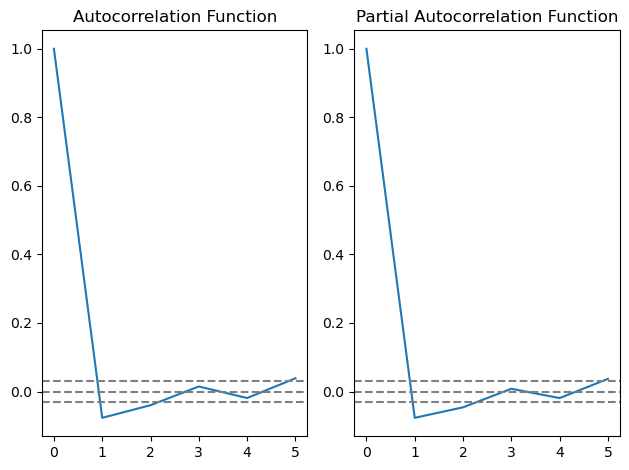

In [40]:
#ACF and PACF plots - rolling mean:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(tsLogDiffN_noOut, nlags=5)
lag_pacf = pacf(tsLogDiffN_noOut, nlags=5, method='ols')

#Plot ACF (q -> model MA): 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsLogDiffN_noOut)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsLogDiffN_noOut)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF (p -> model AR): 
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsLogDiffN_noOut)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsLogDiffN_noOut)),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.tight_layout()

In [43]:
#converting the index to datetime
tsLogDiffN_df.index = pd.to_datetime(tsLogDiffN_df.index)
#tsLogDiffN_noOut2.index = pd.to_datetime(tsLogDiffN_noOut2.index)
tsLogDiffN_noOut.index = pd.to_datetime(tsLogDiffN_noOut.index)
tsLogN_df.index = pd.to_datetime(tsLogN_df.index)

#making sure that the index is in order
tsLogDiffN_df.sort_index(inplace=True)
#tsLogDiffN_noOut2.sort_index(inplace=True)
tsLogDiffN_noOut.sort_index(inplace=True)
tsLogN_df.sort_index(inplace=True)

#setting the frequency as daily
tsLogDiffN_df = tsLogDiffN_df.asfreq('D')
#tsLogDiffN_noOut2 = tsLogDiffN_noOut2.asfreq('D')
tsLogDiffN_noOut = tsLogDiffN_noOut.asfreq('D')
tsLogN_df = tsLogN_df.asfreq('D')

In [44]:
from statsmodels.tsa.arima.model import ARIMA

In [45]:
tsLogDiffN_df.rename(columns={'_north(m)':'north(m)'}, inplace=True)

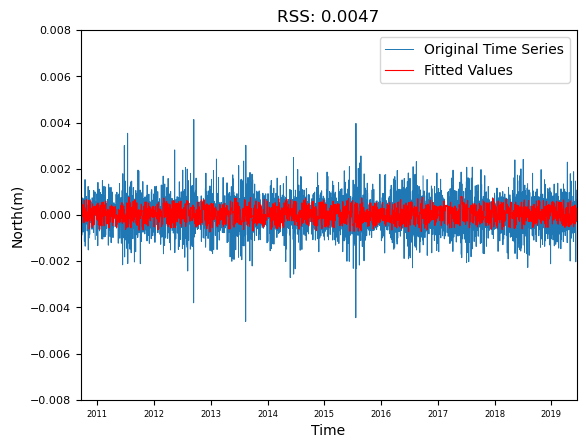

In [46]:
#model AR (Auto-Regressive) -> Plot PACF (p = 1)
modelN_AR = ARIMA(tsLogDiffN_noOut, order=(1, 1, 0))  
resultsN_AR = modelN_AR.fit()
plt.plot(tsLogDiffN_df,  label='Original Time Series', linewidth = 0.7)
plt.plot(resultsN_AR.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)

# Calculate Residual Sum of Squares (RSS)
residuals_AR = resultsN_AR.fittedvalues - tsLogDiffN_df['north(m)']
rss_AR = np.sum(residuals_AR**2, axis=0)

#Ensure rss is a scalar (float)
#rss_scalar = float(rss.iloc[0]) 

# Show the plot
plt.title(f'RSS: {rss_AR:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2019-06-13'))
plt.ylabel('North(m)')
plt.ylim(-0.008,0.008)
plt.yticks(fontsize=8)
plt.show()

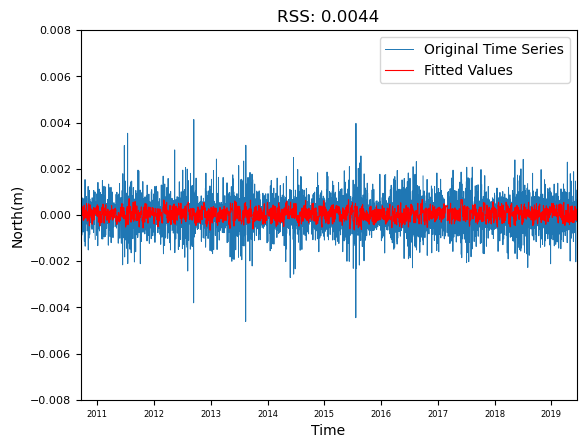

In [47]:
#model MA (Moving Averages) -> Plot ACF (q = 1)
model_MA = ARIMA(tsLogDiffN_noOut, order=(0, 1, 1))  
results_MA = model_MA.fit()  
plt.plot(tsLogDiffN_df, label='Original Time Series', linewidth = 0.7)
plt.plot(results_MA.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)

# Calculate Residual Sum of Squares (RSS)
residuals_MA = results_MA.fittedvalues - tsLogDiffN_df['north(m)']
rss_MA = np.sum(residuals_MA**2, axis=0)


plt.title(f'RSS: {rss_MA:.4f}')
plt.legend()
plt.xlabel('Time')
plt.xticks(fontsize=6)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2019-06-13'))
plt.ylabel('North(m)')
plt.ylim(-0.008,0.008)
plt.yticks(fontsize=8)
plt.show()

/Users/rafaelaoliveira/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rafaelaoliveira/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


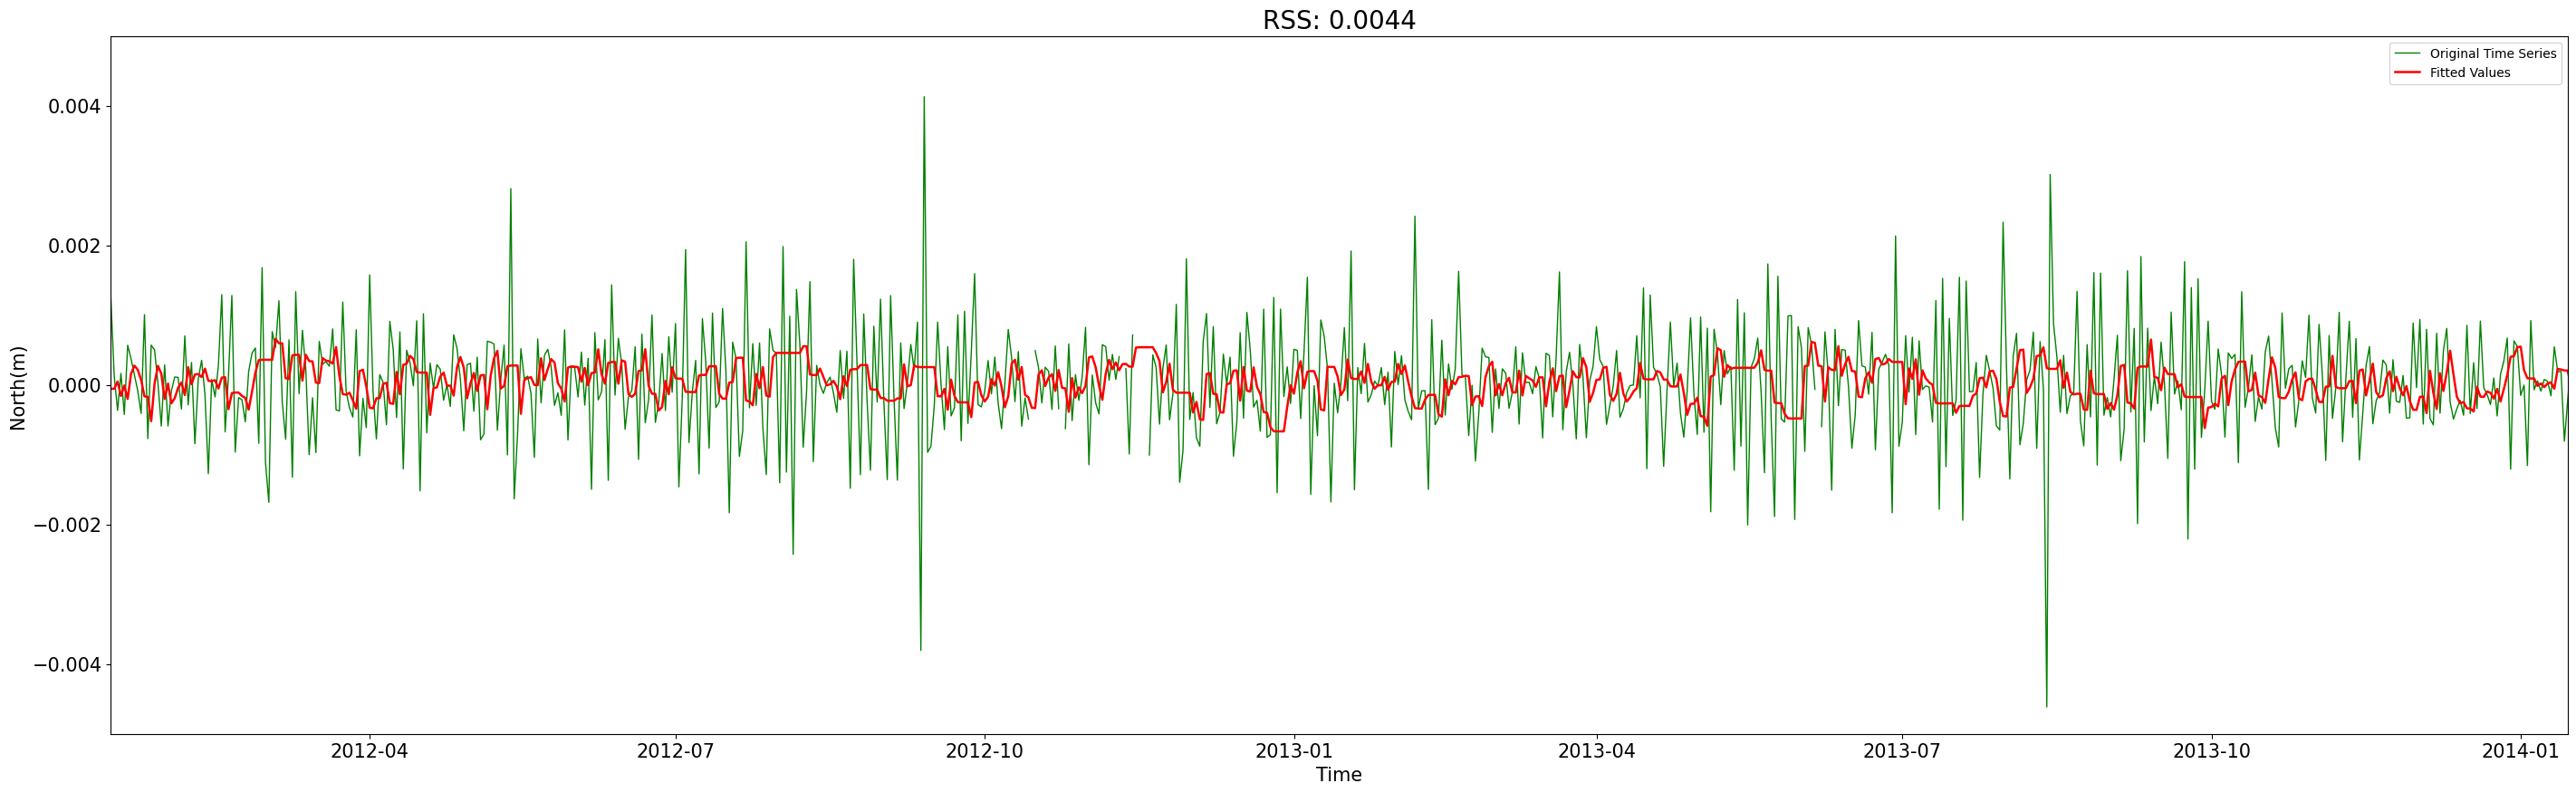

In [61]:
#combined - model ARIMA  p = 1 and q = 1:
#Auto-Regressive Integrated Moving Averages
model_ARIMA = ARIMA(tsLogDiffN_noOut, order=(1, 1, 1))  
results_ARIMA = model_ARIMA.fit()  

model_ARIMA2 = ARIMA(tsLogDiffN_noOut, order=(1, 1, 1))
results_ARIMA2 = model_ARIMA2.fit()
model2= results_ARIMA2.fittedvalues

fig=plt.figure(figsize=(35,10))
plt.plot(tsLogDiffN_df, color='green', label='Original Time Series', linewidth = 1.)
plt.plot(model2,color='red', label='Fitted Values', linewidth= 1.8)

# Calculate Residual Sum of Squares (RSS)
residuals_ARIMA = results_ARIMA.fittedvalues - tsLogDiffN_df['north(m)']
rss_ARIMA = np.sum(residuals_ARIMA**2, axis=0)

plt.title(f'RSS: {rss_ARIMA:.4f}', fontsize=20)
plt.legend()
plt.xlabel('Time', fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))
plt.ylabel('North(m)', fontsize=15)
plt.ylim(-0.005,0.005)
plt.yticks(fontsize=15)

fl = 'pord_north.svg'
f = io.BytesIO()
plt.savefig(fl, format="svg")

#ARIMA for outlier replaced
model_ARIMA_outDel = ARIMA(tsLogDiffN_noOut2, order=(1, 0, 1))
results_ARIMA_outDel = model_ARIMA_outDel.fit() 

#Plot rep: 
plt.subplot(121) 
plt.plot(tsLogDiffN_df, label='Original Time Series', linewidth = 0.4)
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2011-03-15'))
plt.title('Outliers Replaced')

#Plot del: 
plt.subplot(122)
plt.plot(tsLogDiffN_df, label='Original Time Series', linewidth = 0.4)
plt.plot(results_ARIMA_outDel.fittedvalues, color='red', label='Fitted Values', linewidth= 0.8)
plt.xlim(pd.Timestamp('2010-09-15'), pd.Timestamp('2020-06-13'))
plt.title('Outliers Removed')
plt.tight_layout()

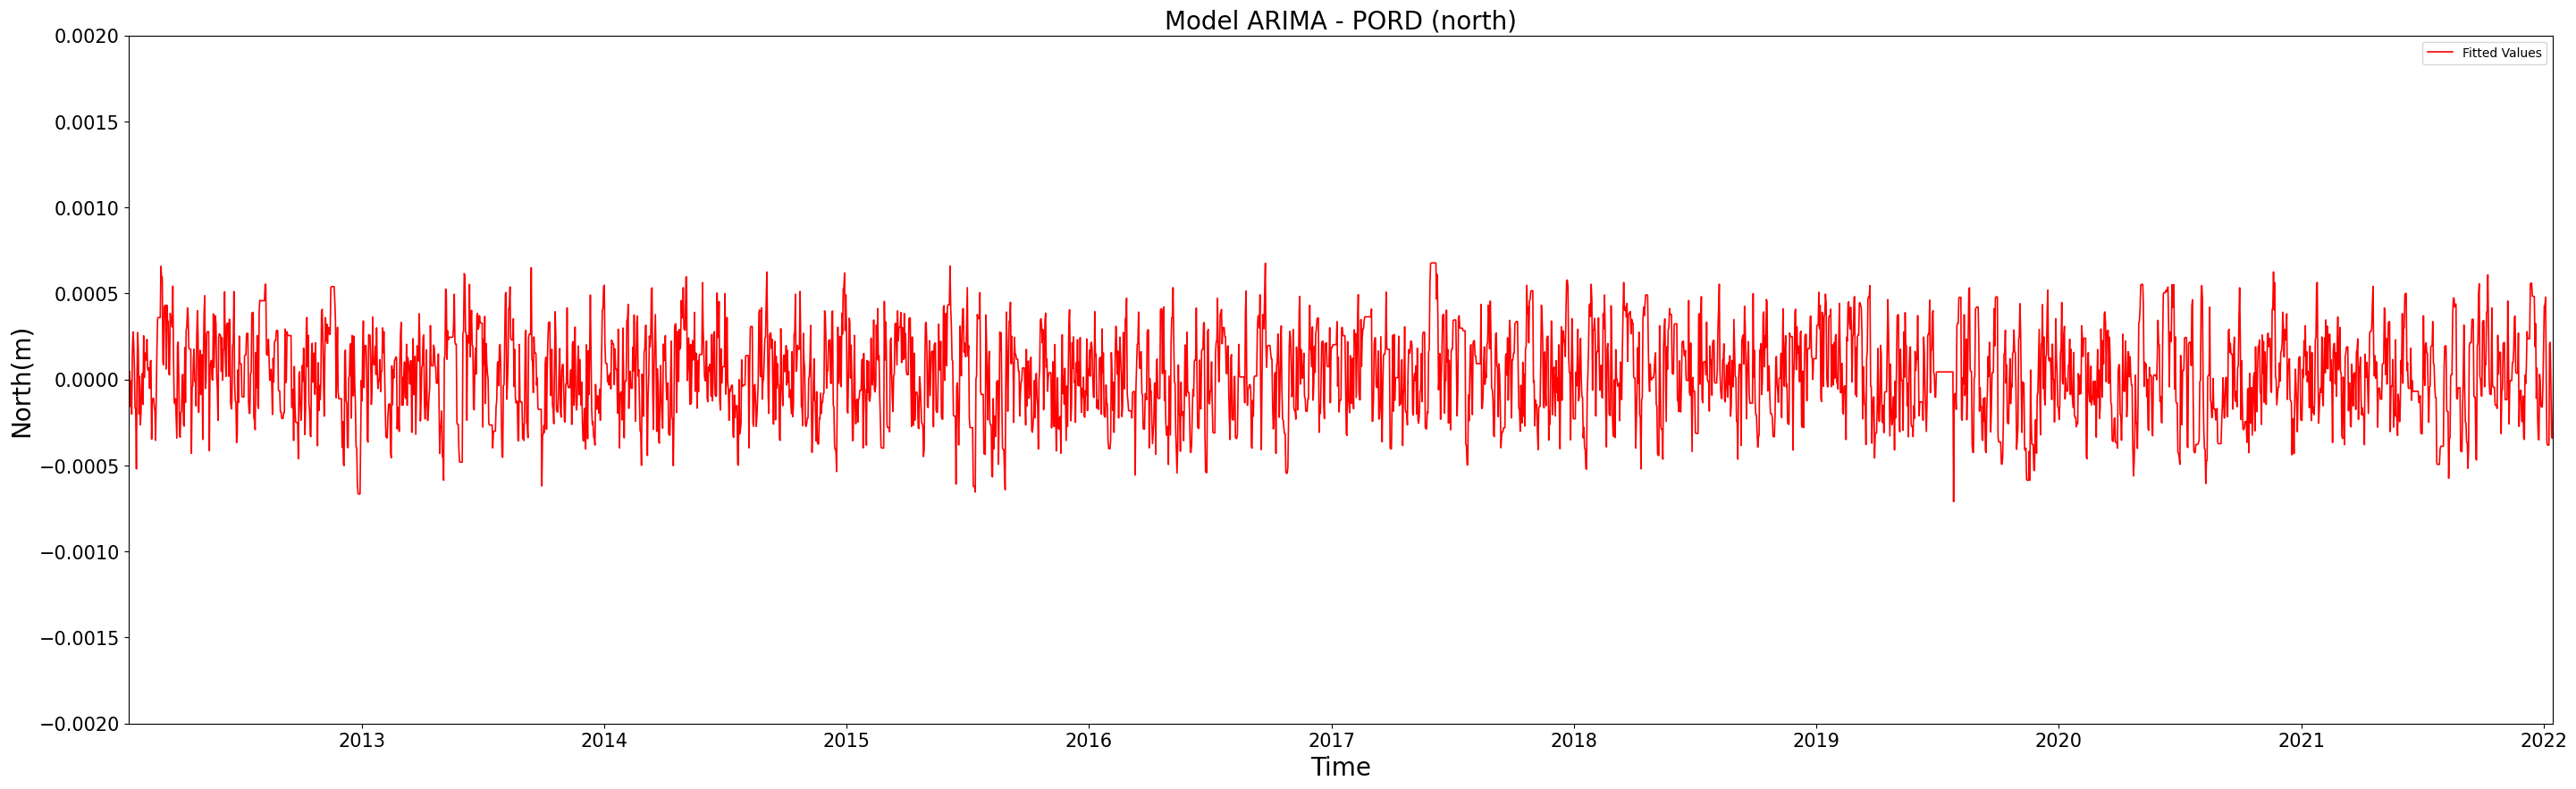

In [67]:
fig=plt.figure(figsize=(35,10))
#plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted Values', linewidth= 1.2)
plt.plot(model2, color='red', label='Fitted Values', linewidth= 1.2)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2014-01-15'))

plt.title('Model ARIMA - PORD (north)', fontsize=20)
plt.legend()
plt.xlabel('Time', fontsize=20)
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2022-01-15'))
plt.ylabel('North(m)', fontsize=20)
plt.ylim(-0.002,0.002)
plt.yticks(fontsize=15)

fl = 'pord_arimas_north.svg'
f = io.BytesIO()
#plt.savefig(fl, format="svg")
plt.show()

In [68]:
model2

YYMMMDD
2006-08-28    0.000000
2006-08-29    0.000182
2006-08-30    0.000182
2006-08-31    0.000182
2006-09-01    0.000395
                ...   
2022-12-24    0.000392
2022-12-25    0.000060
2022-12-26    0.000138
2022-12-27    0.000181
2022-12-28    0.000275
Freq: D, Length: 5967, dtype: float64

In [78]:
print(model2)
print(meanMonth)

YYMMMDD
2006-08-28    0.000000
2006-08-29    0.000182
2006-08-30    0.000182
2006-08-31    0.000182
2006-09-01    0.000395
                ...   
2022-12-24    0.000392
2022-12-25    0.000060
2022-12-26    0.000138
2022-12-27    0.000181
2022-12-28    0.000275
Freq: D, Length: 5967, dtype: float64
YYMMMDD
2006-08-31    0.000136
2006-09-30   -0.000084
2006-10-31   -0.000098
2006-11-30   -0.000084
2006-12-31   -0.000015
                ...   
2022-08-31   -0.000253
2022-09-30   -0.000131
2022-10-31    0.000075
2022-11-30    0.000070
2022-12-31    0.000023
Freq: M, Length: 197, dtype: float64


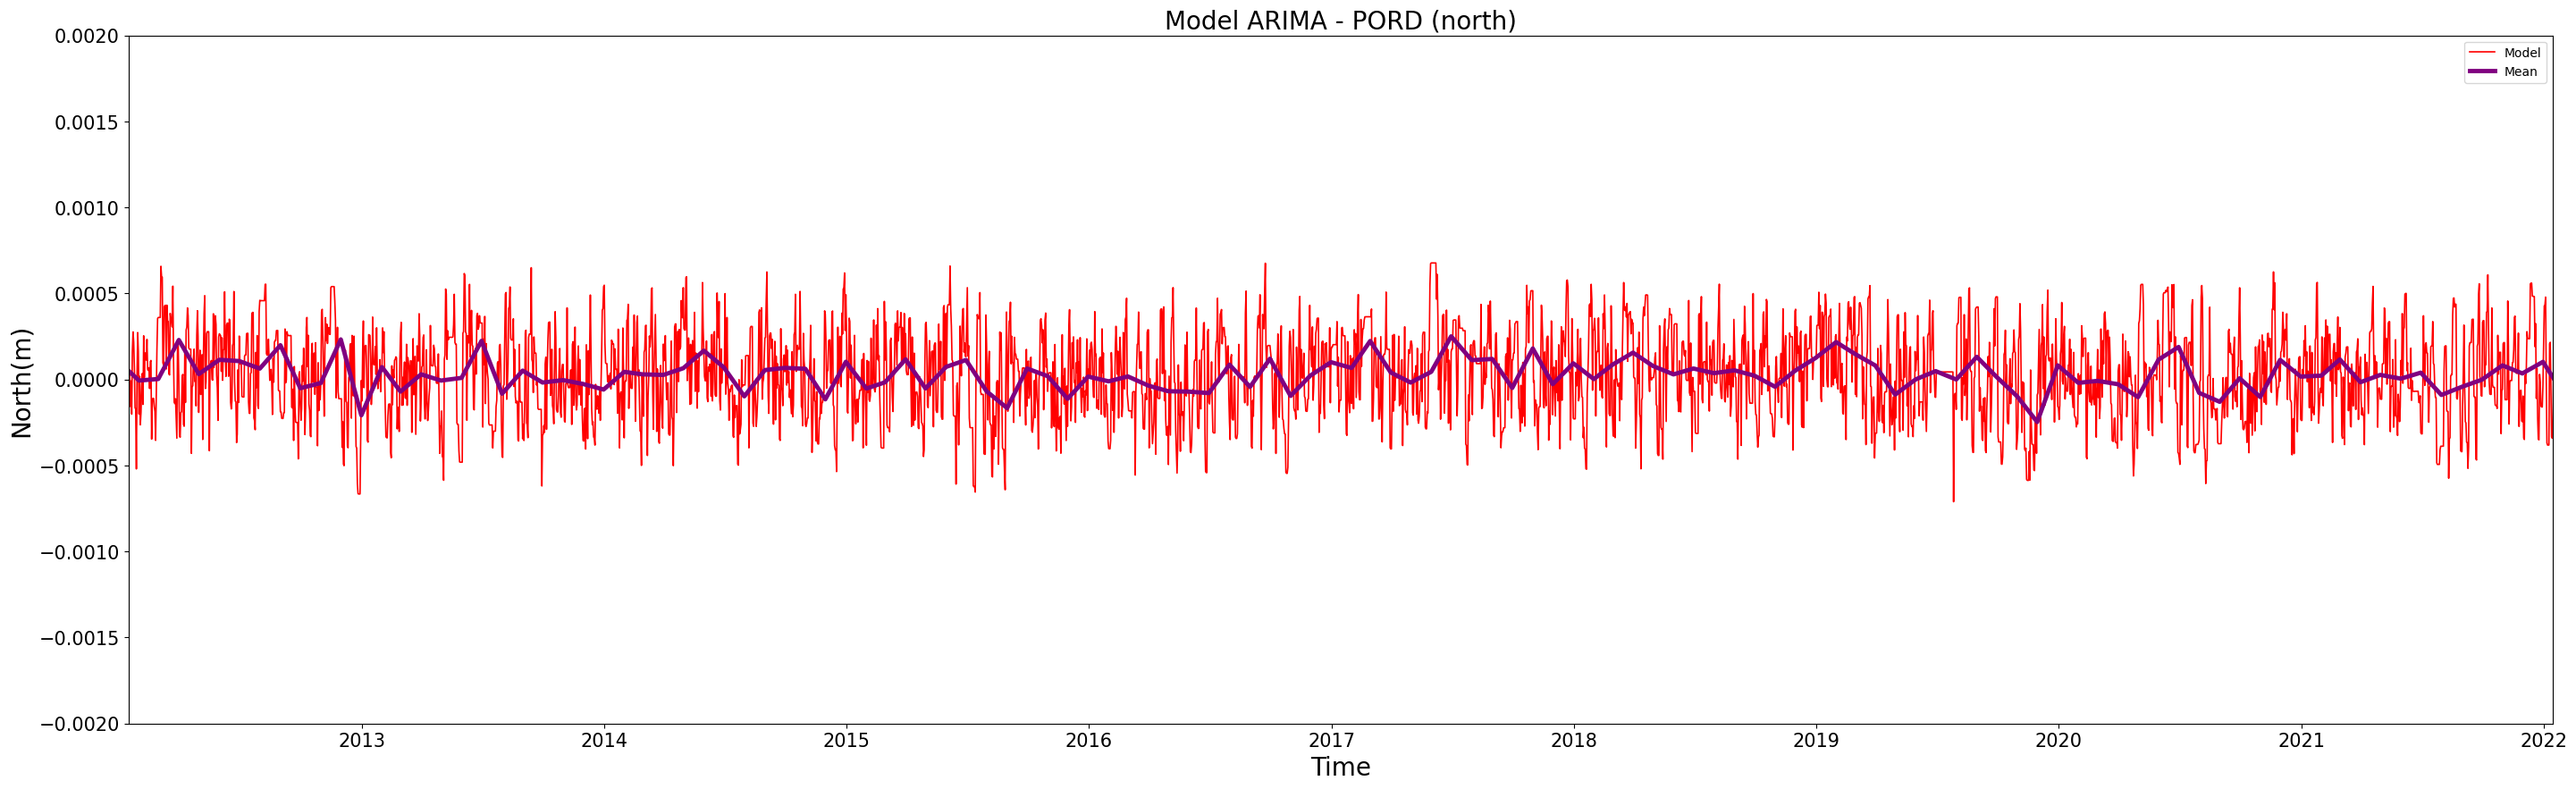

In [93]:
#converting the index to datetime
model2.index = pd.to_datetime(model2.index)

#making sure that the index is in order
model2.sort_index(inplace=True)

meanMonth = model2.resample('M').mean()


fig=plt.figure(figsize=(35,10))
plt.plot(model2, color='red', label='Model', linewidth= 1.2)
plt.plot(meanMonth, color='purple', label='Mean', lw=3.5)
#plt.xlim(pd.Timestamp('2011-12-31'), pd.Timestamp('2014-01-31'))

plt.title('Model ARIMA - PORD (north)', fontsize=20)
plt.legend()
plt.xlabel('Time', fontsize=20)
plt.xticks(fontsize=15)
plt.xlim(pd.Timestamp('2012-01-15'), pd.Timestamp('2022-01-15'))
plt.ylabel('North(m)', fontsize=20)
plt.ylim(-0.002,0.002)
plt.yticks(fontsize=15)

plt.show()